In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
from tabulate import tabulate
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import scipy.stats as stats
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False) 

In [3]:
df = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt')
df['Date'] = pd.to_datetime(df['Date'])

# <a id='toc2_'></a>[Preprocessing](#toc0_)

## Splitting Training/Testing data

In [4]:
end_date = df['Date'].max()
test_start_date = end_date - pd.DateOffset(months=18)
validation_start_date = end_date - pd.DateOffset(years=3)

train = df[df['Date'] < validation_start_date]
validation = df[(df['Date'] >= validation_start_date) & (df['Date'] < test_start_date)]
test = df[df['Date'] >= test_start_date]

print("Training Data:")
print(train.head())

print("\nValidation Data:")
print(validation.head())

print("\nTest Data:")
print(test.head())


Training Data:
        Date   Open   High    Low  Close    Volume  OpenInt
0 2005-02-25 104.77 106.00 104.68 105.79  70221808        0
1 2005-02-28 105.55 105.68 104.56 105.08  79695344        0
2 2005-03-01 105.22 105.87 105.22 105.62  54607412        0
3 2005-03-02 105.21 106.22 105.10 105.57  73733090        0
4 2005-03-03 105.99 106.20 105.15 105.61  71286823        0

Validation Data:
           Date   Open   High    Low  Close    Volume  OpenInt
2443 2014-11-10 191.27 191.91 191.05 191.85  70446940        0
2444 2014-11-11 191.93 192.17 191.53 192.05  57848368        0
2445 2014-11-12 191.24 192.11 191.20 191.83  95763862        0
2446 2014-11-13 192.03 192.66 191.12 192.06  90677935        0
2447 2014-11-14 191.97 192.33 191.59 192.11  85469597        0

Test Data:
           Date   Open   High    Low  Close    Volume  OpenInt
2819 2016-05-10 200.57 202.26 200.49 202.24  79620606        0
2820 2016-05-11 201.70 202.33 200.35 200.35  84095183        0
2821 2016-05-12 201.12 201.3

## <a id='toc1_'></a>[EDA](#toc0_)

### <a id='toc1_1_'></a>[Summary statistics](#toc0_)

In [ ]:
train.head()
# latex_table = tabulate(df.head(), headers='keys', tablefmt='latex')
# print(latex_table)

In [ ]:
# train.describe()
latex_table = tabulate(df.describe(), headers='keys', tablefmt='latex', floatfmt=".2f")
print(latex_table)

In [ ]:
train.info()
# latex_table = tabulate(df.info(), headers='keys', tablefmt='latex')
# print(latex_table)

In [ ]:
train.isnull().sum()
# null_counts = df.isnull().sum().reset_index()
# null_counts.columns = ['Column', 'Null Count']
# latex_table = tabulate(null_counts, headers='keys', tablefmt='latex')
# print(latex_table)

In [ ]:
train.duplicated().sum()
# duplicate_count = df.duplicated().sum()
# duplicate_summary = pd.DataFrame({
#     'Description': ['Total Duplicate Rows'],
#     'Count': [duplicate_count]
# })
# latex_table = tabulate(duplicate_summary, headers='keys', tablefmt='latex', showindex=False)
# print(latex_table)


### <a id='toc1_2_'></a>[Distribution](#toc0_)

In [ ]:
# candle chart 

# Convert 'Date' to datetime if not already
train['Date'] = pd.to_datetime(train['Date'])

# Create a copy of the DataFrame for the last month
df_copy = train.copy(deep=True)
df_copy = df_copy[df_copy['Date'] > df_copy['Date'].max() - pd.DateOffset(months=1)]

# Create subplots with individual row heights
fig = make_subplots(rows=2, cols=1, 
                    subplot_titles=(
                        'S&P 500 (SPY) Price Chart 25. february 2005 to 9. november 2014', 
                        'S&P 500 (SPY) Price Chart, 9. october 2014 to 9. november 2014'),
                    vertical_spacing=0.15,
                    row_heights=[0.7, 0.3])  # Adjust the heights as needed

# Add the first candlestick chart (entire data)
fig.add_trace(go.Candlestick(
    x=train['Date'],
    open=train['Open'],
    high=train['High'],
    low=train['Low'],
    close=train['Close'],
    increasing_line_color='green',
    decreasing_line_color='red',
    name=''  # Set the name to an empty string
), row=1, col=1)

# Add the second candlestick chart (last month)
fig.add_trace(go.Candlestick(
    x=df_copy['Date'],
    open=df_copy['Open'],
    high=df_copy['High'],
    low=df_copy['Low'],
    close=df_copy['Close'],
    increasing_line_color='green',
    decreasing_line_color='red',
    name=''  # Set the name to an empty string
), row=2, col=1)

# Update layout settings
fig.update_layout(
    title='S&P 500 (SPY) Price Charts',
    xaxis_title='Date',
    yaxis_title='Price features',
    xaxis_rangeslider_visible=False,  # Disable range slider for the first x-axis
    height=1000,  # Overall height for the entire figure
    showlegend=False  # Hide the legend
)

# Disable range slider for the second x-axis
fig.update_xaxes(rangeslider_visible=False, row=2, col=1)

# Optionally, adjust the y-axes for each subplot
fig.update_yaxes(title_text='Price features', row=1, col=1)
fig.update_yaxes(title_text='Price features', row=2, col=1)

# Show the plot
fig.show()


### <a id='toc1_3_'></a>[Histrograms for distributions](#toc0_)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with 'Open', 'Close', 'High', 'Low', and 'Volume' columns

# Set up a figure with 1 row and 5 columns
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

# Define column names and colors for easy iteration
columns = ['Open', 'Close', 'High', 'Low', 'Volume']
colors = ['blue', 'green', 'orange', 'purple', 'red']

# Plot a histogram for each column
for i, column in enumerate(columns):
    axes[i].hist(train[column], bins=100, color=colors[i], alpha=0.7)
    axes[i].set_title(f'{column} Distribution')
    axes[i].set_xlabel(f'{column} {"Price" if column != "Volume" else ""}')  # Set x-axis label
    axes[i].set_ylabel('Frequency')  # Set y-axis label for each plot

# Adjust layout to ensure readability
plt.tight_layout()
plt.show()


## <a id='toc2_2_'></a>[Sliding window time series](#toc0_)

In [ ]:
# Create a column for anomaly detection
close_column = train['Close']
open_column = train['Open']
low_column = train['Low']
high_column = train['High']

# Parameters for the sliding window
window_percentage = 3  # Percentage for the window size
k_close = int(len(close_column) * (window_percentage / 2 / 100))
k_open = int(len(open_column) * (window_percentage / 2 / 100))
k_low = int(len(low_column) * (window_percentage / 2 / 100))
k_high = int(len(high_column) * (window_percentage / 2 / 100))

N = len(close_column)

# Function to get upper and lower bands
def get_bands(data, k):
    bands = []
    for i in range(N):
        if i < k or i + k >= N:
            bands.append((np.nan, np.nan))  # Avoiding edge effects
            continue
        window_data = data[i-k:i+k]
        bands.append((np.mean(window_data) + 3 * np.std(window_data),
                      np.mean(window_data) - 3 * np.std(window_data)))
    return zip(*bands)

# Calculate bands for each price type
upper_close, lower_close = get_bands(close_column, k_close)
upper_open, lower_open = get_bands(open_column, k_open)
upper_low, lower_low = get_bands(low_column, k_low)
upper_high, lower_high = get_bands(high_column, k_high)

# Identify anomalies for each price type
anomalies_close = (close_column > upper_close) | (close_column < lower_close)
anomalies_open = (open_column > upper_open) | (open_column < lower_open)
anomalies_low = (low_column > upper_low) | (low_column < lower_low)
anomalies_high = (high_column > upper_high) | (high_column < lower_high)

# Add anomaly information to the DataFrame
train['Anomalies_Close'] = anomalies_close
train['Anomalies_Open'] = anomalies_open
train['Anomalies_Low'] = anomalies_low
train['Anomalies_High'] = anomalies_high

# Create 2x2 subplots with tighter spacing and equal dimensions
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Closing Prices', 'Opening Prices', 'Low Prices', 'High Prices'),
    vertical_spacing=0.1,  # Adjust vertical spacing
    horizontal_spacing=0.1,  # Adjust horizontal spacing
    shared_xaxes=True,
    shared_yaxes=True,
)

# Add traces for Closing Prices
fig.add_trace(go.Scatter(x=train['Date'], y=close_column, mode='lines', name='Close', line=dict(color='blue')),
              row=1, col=1)
fig.add_trace(go.Scatter(x=train['Date'], y=upper_close, mode='lines', name='Upper Band', line=dict(color='red', dash='dash')),
              row=1, col=1)
fig.add_trace(go.Scatter(x=train['Date'], y=lower_close, mode='lines', name='Lower Band', line=dict(color='green', dash='dash')),
              row=1, col=1)
fig.add_trace(go.Scatter(x=train[train['Anomalies_Close']]['Date'], 
                         y=train[train['Anomalies_Close']]['Close'], 
                         mode='markers', name='Anomalies', marker=dict(color='orange', size=10)),
              row=1, col=1)

# Add traces for Opening Prices
fig.add_trace(go.Scatter(x=train['Date'], y=open_column, mode='lines', name='Open', line=dict(color='blue')),
              row=1, col=2)
fig.add_trace(go.Scatter(x=train['Date'], y=upper_open, mode='lines', name='Upper Band', line=dict(color='red', dash='dash')),
              row=1, col=2)
fig.add_trace(go.Scatter(x=train['Date'], y=lower_open, mode='lines', name='Lower Band', line=dict(color='green', dash='dash')),
              row=1, col=2)
fig.add_trace(go.Scatter(x=train[train['Anomalies_Open']]['Date'], 
                         y=train[train['Anomalies_Open']]['Open'], 
                         mode='markers', name='Anomalies', marker=dict(color='orange', size=10)),
              row=1, col=2)

# Add traces for Low Prices
fig.add_trace(go.Scatter(x=train['Date'], y=low_column, mode='lines', name='Low', line=dict(color='blue')),
              row=2, col=1)
fig.add_trace(go.Scatter(x=train['Date'], y=upper_low, mode='lines', name='Upper Band', line=dict(color='red', dash='dash')),
              row=2, col=1)
fig.add_trace(go.Scatter(x=train['Date'], y=lower_low, mode='lines', name='Lower Band', line=dict(color='green', dash='dash')),
              row=2, col=1)
fig.add_trace(go.Scatter(x=train[train['Anomalies_Low']]['Date'], 
                         y=train[train['Anomalies_Low']]['Low'], 
                         mode='markers', name='Anomalies', marker=dict(color='orange', size=10)),
              row=2, col=1)

# Add traces for High Prices
fig.add_trace(go.Scatter(x=train['Date'], y=high_column, mode='lines', name='High', line=dict(color='blue')),
              row=2, col=2)
fig.add_trace(go.Scatter(x=train['Date'], y=upper_high, mode='lines', name='Upper Band', line=dict(color='red', dash='dash')),
              row=2, col=2)
fig.add_trace(go.Scatter(x=train['Date'], y=lower_high, mode='lines', name='Lower Band', line=dict(color='green', dash='dash')),
              row=2, col=2)
fig.add_trace(go.Scatter(x=train[train['Anomalies_High']]['Date'], 
                         y=train[train['Anomalies_High']]['High'], 
                         mode='markers', name='Anomalies', marker=dict(color='orange', size=10)),
              row=2, col=2)

# Update layout settings and set margins to ensure equal dimensions for all subplots
fig.update_layout(
    title='Stock Prices with Outlier Detection',
    height=800,
    width=1200,
    showlegend=False,
    margin=dict(l=10, r=10, t=40, b=40),
    xaxis_title="Date",
    yaxis_title="Close Price",
    xaxis=dict(tickformat="%Y-%m-%d")  # Add date format for x-axis
)

# Show the plot
fig.show()


In [ ]:
# Fjerner de kolonnene som ble brukt til å markere "outliers", ettersom jeg argumenterte for at de ikke skal fjernes.
train.drop(columns=['Anomalies_Close', 'Anomalies_Open', 'Anomalies_High', 'Anomalies_Low'], inplace=True)

# <a id='toc3_'></a>[Transformation](#toc0_)

## <a id='toc3_1_'></a>[Adding optimal (15x weekly) lag features](#toc0_)

In [5]:
def create_weekly_lagged_features(df, num_weeks):
    df_lagged = df.copy()
    lagged_data = [df]
    for col in df.columns.drop('Date'):
        for i in range(1, num_weeks + 1):
            df_lagged[f'{col}_lag_{i*5}'] = df[col].shift(i * 5)
            lagged_data.append(df[col].shift(i * 5).rename(f'{col}_lag_{i*5}'))
    df_lagged = pd.concat(lagged_data, axis=1)
    return df_lagged

# Add 15 weekly lagged features to the DataFrame
train = create_weekly_lagged_features(train, 15)

# Drop rows with NaN values due to lagging
train.dropna(inplace=True)
train.reset_index(drop=True, inplace=True)

In [ ]:
train = train
validation = validation
test = test

## <a id='toc3_2_'></a>[Encoding categorical data](#toc0_)

In [6]:
def encode_cyclical(a, max_value):
    x = (np.sin(2 * np.pi * a) + 1) / max_value
    y = (np.cos(2 * np.pi * a) + 1) / max_value
    return x, y
    
def encode_df(df):
    df['year'] = df['Date'].dt.year # This one is continious and numeric, must be scaled later
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['day_of_week'] = df['Date'].dt.day_of_week
    df['day_of_year'] = df['Date'].dt.day_of_year
    df['is_month_end'] = df['Date'].dt.is_month_end
    df['is_leap_year'] = df['Date'].dt.is_leap_year
    
    # These are numerical, cyclic encoding for them
    df['month_sin'], df['month_cos'] = encode_cyclical(df['month'], 12)
    df['day_sin'], df['day_cos'] = encode_cyclical(df['day'], 31)
    df['day_of_week_sin'], df['day_of_week_cos'] = encode_cyclical(df['day_of_week'], 7)
    df['day_of_year_sin'], df['day_of_year_cos'] = encode_cyclical(df['day_of_year'], 366)
    
    # These ones are categorical, one hot for them
    df = pd.get_dummies(df, columns=['is_month_end', 'is_leap_year']).astype(np.int64)
    
     # kan kanskje flytte denne over til den seksjonen hvor man fjerner features og sånn
    # df = df.drop(columns=['Date', 'month', 'day', 'day_of_week', 'day_of_year'])
    df = df.drop(columns=['month', 'day', 'day_of_week', 'day_of_year'])


    return df
    
train = encode_df(train)
validation = encode_df(validation)
test = encode_df(test)


C:\Users\ander\AppData\Local\Temp\ipykernel_10144\3134136995.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['month_sin'], df['month_cos'] = encode_cyclical(df['month'], 12)
C:\Users\ander\AppData\Local\Temp\ipykernel_10144\3134136995.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['month_sin'], df['month_cos'] = encode_cyclical(df['month'], 12)
C:\Users\ander\AppData\Local\Temp\ipykernel_10144\3134136995.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inse

## <a id='toc3_3_'></a>[Log-transforming skewed volume data](#toc0_)

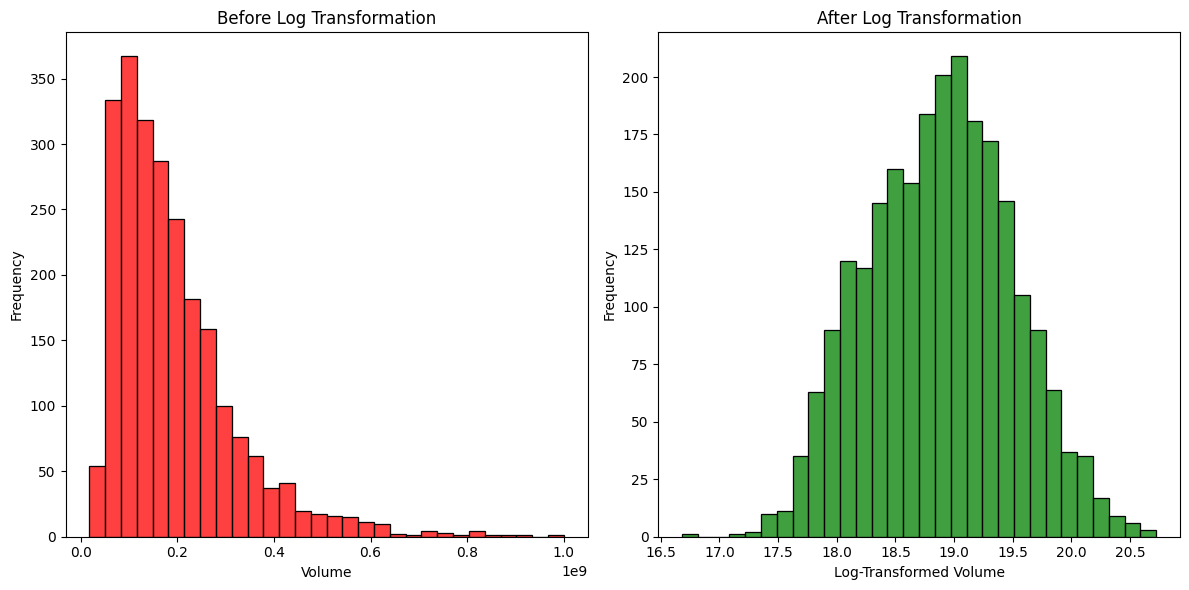

In [7]:
plt.figure(figsize=(12, 6))

# Plot before log transformation
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
sns.histplot(train['Volume'], bins=30, color='red')
plt.title('Before Log Transformation')
plt.xlabel('Volume')
plt.ylabel('Frequency')

# Apply log transformation
train['Volume'] = np.log1p(train['Volume'])  # log transformer den fordi den var skækk
validation['Volume'] = np.log1p(validation['Volume'])  # log transformer den fordi den var skækk
test['Volume'] = np.log1p(test['Volume'])  # log transformer den fordi den var skækk, samme for alle

# Plot after log transformation
plt.subplot(1, 2, 2)  # (rows, columns, panel number)
sns.histplot(train['Volume'], bins=30, color='green')
plt.title('After Log Transformation')
plt.xlabel('Log-Transformed Volume')
plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## <a id='toc3_4_'></a>[Normalizing to scale numerical features](#toc0_)

In [8]:
features_to_scale = ['Open', 'Close', 'High', 'Low', 'Volume', 'year']
def normalize_numerical_features(df):
    scaler = MinMaxScaler()
    columns_to_scale = [col for col in df.columns if any(feature in col for feature in features_to_scale)]
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
 
normalize_numerical_features(train)
# normalize_numerical_features(validation)
# normalize_numerical_features(test)

# <a id='toc4_'></a>[Feature Extraction](#toc0_)

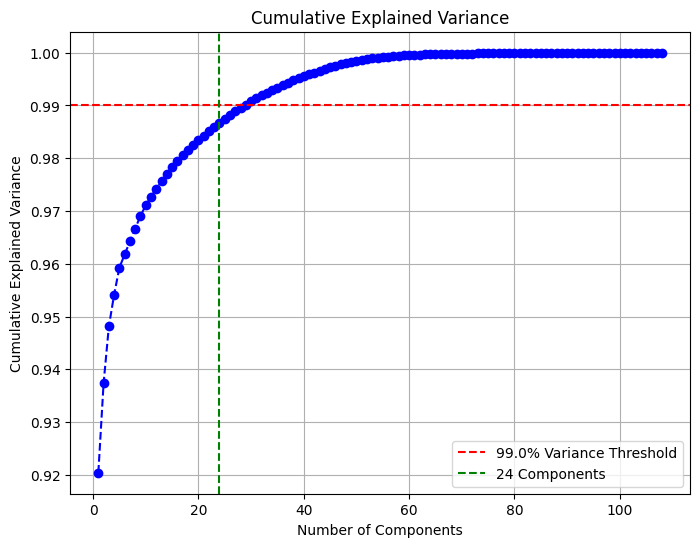

Selected 24 components based on 99.0% variance requirement.


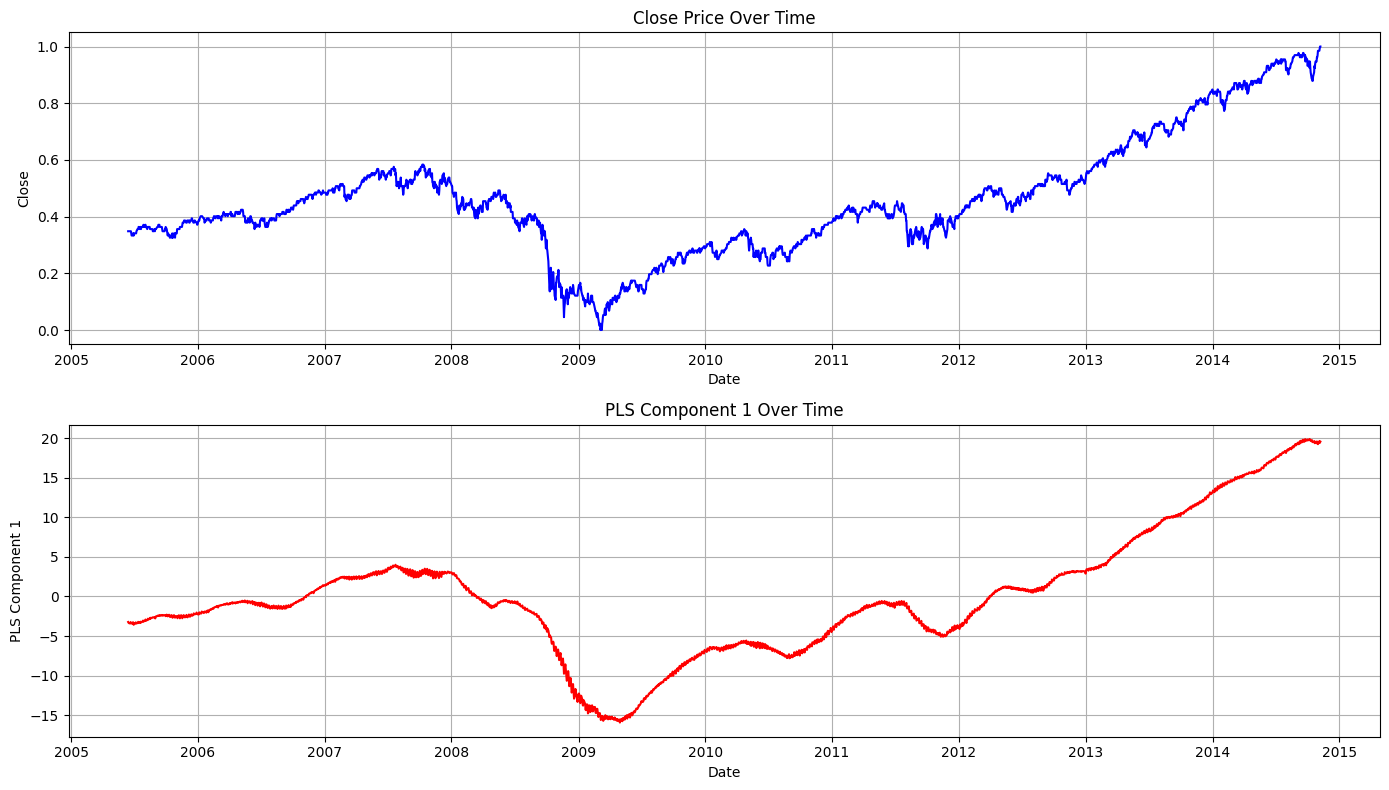

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler

# Constants
REQUIRED_VARIANCE = 0.99
TARGET_VARIABLE = 'Close'  # Replace with your target variable name

def feature_extract(train, validation=pd.DataFrame(), test=pd.DataFrame()):
    # Preserve the Date column separately for later plotting
    train_date = train['Date']
    validation_date = validation['Date']
    test_date = test['Date']
    
    # Drop the Date column for feature extraction
    data_train = train.drop('Date', axis=1)
    data_validation = validation.drop('Date', axis=1)
    data_test = test.drop('Date', axis=1)
    
    # Separate features and target variable
    X_train = data_train.drop(TARGET_VARIABLE, axis=1)
    y_train = data_train[TARGET_VARIABLE]
    X_validation = data_validation.drop(TARGET_VARIABLE, axis=1)
    y_validation = data_validation[TARGET_VARIABLE]
    X_test = data_test.drop(TARGET_VARIABLE, axis=1)
    y_test = data_test[TARGET_VARIABLE]
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled_train = scaler.fit_transform(X_train)
    
    # Use the same scaler to transform the validation and test data
    X_scaled_validation = scaler.transform(X_validation)
    X_scaled_test = scaler.transform(X_test)
    
    # Initialize the PLS model with the minimum number of components
    N_COMPONENTS = min(X_scaled_train.shape)
    pls_train = PLSRegression(n_components=N_COMPONENTS)
    pls_validation = PLSRegression(n_components=N_COMPONENTS)
    pls_test = PLSRegression(n_components=N_COMPONENTS)
    
    # Fit the PLS model
    pls_train.fit(X_scaled_train, y_train)
    pls_validation.fit(X_scaled_validation, y_validation)
    pls_test.fit(X_scaled_test, y_test)
    
    # Transform the data using PLS components
    X_transformed_train = pls_train.transform(X_scaled_train)
    X_transformed_validation = pls_validation.transform(X_scaled_validation)
    X_transformed_test = pls_test.transform(X_scaled_test)
    
    # Calculate explained variance
    explained_variance = np.var(X_transformed_train, axis=0)
    explained_variance_ratio = explained_variance / explained_variance.sum()
    sorted_idx = np.argsort(explained_variance_ratio)[::-1]
    explained_variance_ratio_sorted = explained_variance_ratio[sorted_idx]
    cumulative_variance_sorted = np.cumsum(explained_variance_ratio_sorted)
    
    # Find the number of components that meet the required variance threshold
    n_components_required = 24
    
    # Plot cumulative explained variance
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_variance_sorted) + 1), cumulative_variance_sorted, marker='o', linestyle='--', color='b')
    plt.axhline(y=REQUIRED_VARIANCE, color='r', linestyle='--', label=f'{REQUIRED_VARIANCE*100}% Variance Threshold')
    plt.axvline(x=n_components_required, color='g', linestyle='--', label=f'{n_components_required} Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Select the required number of components
    X_reduced_train = X_transformed_train[:, sorted_idx[:n_components_required]]
    X_reduced_validation = X_transformed_validation[:, sorted_idx[:n_components_required]]
    X_reduced_test = X_transformed_test[:, sorted_idx[:n_components_required]]
    
    # Convert to DataFrame with appropriate column names
    X_reduced_train_df = pd.DataFrame(X_reduced_train, columns=[f'PLS_Component_{i+1}' for i in range(n_components_required)])
    X_reduced_validation_df = pd.DataFrame(X_reduced_validation, columns=[f'PLS_Component_{i+1}' for i in range(n_components_required)])
    X_reduced_test_df = pd.DataFrame(X_reduced_test, columns=[f'PLS_Component_{i+1}' for i in range(n_components_required)])
    
    # Step 3: Final feature set with target variable 'Close' as the first column
    train = pd.concat([train_date, pd.Series(y_train, name=TARGET_VARIABLE), X_reduced_train_df], axis=1)
    validation = pd.concat([validation_date, pd.Series(y_validation, name=TARGET_VARIABLE), X_reduced_validation_df], axis=1)
    test = pd.concat([test_date, pd.Series(y_test, name=TARGET_VARIABLE), X_reduced_test_df], axis=1)
    train['Date'] = pd.to_datetime(train['Date'], unit='ns')
    validation['Date'] = pd.to_datetime(validation['Date'], unit='ns')
    test['Date'] = pd.to_datetime(test['Date'], unit='ns')
    # Display the selected components and their variance
    print(f"Selected {n_components_required} components based on {REQUIRED_VARIANCE*100}% variance requirement.")
    
    return train, validation, test

# Assuming train, validation, and test are already defined DataFrames
train, _, _ = feature_extract(train, train.copy(), train.copy())

# Now let's plot the Close values and PLS components alongside each other

# Plotting Close and PLS Component(s) for train data (you can adjust this for validation and test data)
plt.figure(figsize=(14, 8))

# Plot Close
plt.subplot(2, 1, 1)
plt.plot(train['Date'], train[TARGET_VARIABLE], label='Close', color='b')
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Close Price Over Time')
plt.grid(True)

# Plot first PLS Component
plt.subplot(2, 1, 2)
plt.plot(train['Date'], train['PLS_Component_1'], label='PLS Component 1', color='r')
plt.xlabel('Date')
plt.ylabel('PLS Component 1')
plt.title('PLS Component 1 Over Time')
plt.grid(True)

plt.tight_layout()
plt.show()


# <a id='toc5_'></a>[Feature Selection](#toc0_)

## <a id='toc5_1_'></a>[Correlation Matrix](#toc0_)

In [ ]:
corr = train.drop('Date', axis=1).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Selected PLS Components')
plt.show()

## <a id='toc5_2_'></a>[Filter, wrapper, and embedded](#toc0_)

Optimal number of features (Filter Method): 23
Optimal number of features (Wrapper Method): 21
Optimal number of features (Embedded Method - Lasso): 24
Best Method: Embedded
Optimal Number of Features: 24
Selected Features: ['PLS_Component_1', 'PLS_Component_23', 'PLS_Component_2', 'PLS_Component_3', 'PLS_Component_4', 'PLS_Component_5', 'PLS_Component_6', 'PLS_Component_7', 'PLS_Component_8', 'PLS_Component_9', 'PLS_Component_10', 'PLS_Component_11', 'PLS_Component_24', 'PLS_Component_13', 'PLS_Component_14', 'PLS_Component_15', 'PLS_Component_16', 'PLS_Component_17', 'PLS_Component_18', 'PLS_Component_19', 'PLS_Component_20', 'PLS_Component_21', 'PLS_Component_22', 'PLS_Component_12']


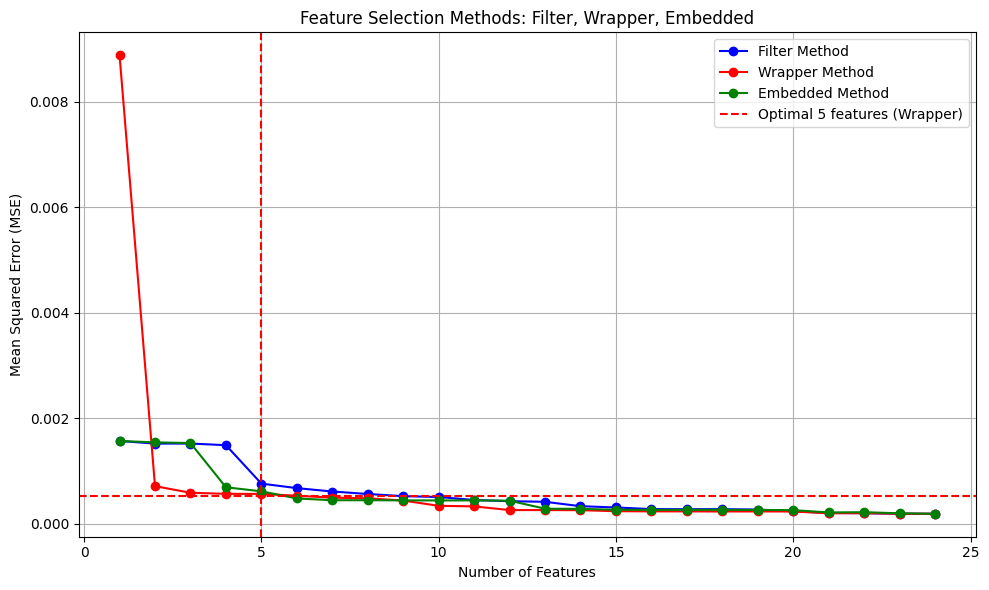

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# ------------------- Constants -------------------
LAMBDA_PARAM = 0.000005  # Penalty term to balance MSE vs. Number of Features
df = train.copy()
df = df.drop(columns=['Date'])
X = df.drop(columns=['Close'])
y = df['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Linear Regression model
model = LinearRegression()

# ------------------- Filter Method (ANOVA F-test) -------------------
num_features_list_filter = []
mse_filter_list = []

# Evaluate different numbers of features using ANOVA F-test
for num_features in range(1, X.shape[1] + 1):
    filter_selector = SelectKBest(score_func=f_regression, k=num_features)
    X_train_selected = filter_selector.fit_transform(X_train, y_train)
    X_test_selected = filter_selector.transform(X_test)

    model.fit(X_train_selected, y_train)
    y_test_pred = model.predict(X_test_selected)
    mse = mean_squared_error(y_test, y_test_pred)
    
    num_features_list_filter.append(num_features)
    mse_filter_list.append(mse)

# Calculate tradeoff score
tradeoff_filter_list = [mse + LAMBDA_PARAM * num_features for mse, num_features in zip(mse_filter_list, num_features_list_filter)]

optimal_index_filter = np.argmin(tradeoff_filter_list)
optimal_num_features_filter = num_features_list_filter[optimal_index_filter]
optimal_mse_filter = mse_filter_list[optimal_index_filter]
print(f"Optimal number of features (Filter Method): {optimal_num_features_filter}")

# ------------------- Wrapper Method (RFE) -------------------
num_features_list_wrapper = []
mse_wrapper_list = []

# Evaluate different numbers of features using RFE
for num_features in range(1, X.shape[1] + 1):
    rfe = RFE(estimator=model, n_features_to_select=num_features)
    rfe.fit(X_train, y_train)

    X_train_selected = rfe.transform(X_train)
    X_test_selected = rfe.transform(X_test)

    model.fit(X_train_selected, y_train)
    y_test_pred = model.predict(X_test_selected)
    mse = mean_squared_error(y_test, y_test_pred)
    
    num_features_list_wrapper.append(num_features)
    mse_wrapper_list.append(mse)

# Calculate tradeoff score
tradeoff_wrapper_list = [mse + LAMBDA_PARAM * num_features for mse, num_features in zip(mse_wrapper_list, num_features_list_wrapper)]

optimal_index_wrapper = np.argmin(tradeoff_wrapper_list)
optimal_num_features_wrapper = num_features_list_wrapper[optimal_index_wrapper]
optimal_mse_wrapper = mse_wrapper_list[optimal_index_wrapper]
print(f"Optimal number of features (Wrapper Method): {optimal_num_features_wrapper}")

# ------------------- Embedded Method (Lasso) -------------------
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
importance = np.abs(lasso.coef_)
top_features_idx = np.argsort(importance)[::-1]

num_features_list_embedded = []
mse_embedded_list = []

for i in range(1, len(top_features_idx) + 1):
    X_train_selected = X_train.iloc[:, top_features_idx[:i]]
    X_test_selected = X_test.iloc[:, top_features_idx[:i]]
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_test_pred = model.predict(X_test_selected)
    mse = mean_squared_error(y_test, y_test_pred)
    
    num_features_list_embedded.append(i)
    mse_embedded_list.append(mse)

# Calculate tradeoff score
tradeoff_embedded_list = [mse + LAMBDA_PARAM * num_features for mse, num_features in zip(mse_embedded_list, num_features_list_embedded)]

optimal_index_embedded = np.argmin(tradeoff_embedded_list)
optimal_num_features_embedded = num_features_list_embedded[optimal_index_embedded]
optimal_mse_embedded = mse_embedded_list[optimal_index_embedded]
print(f"Optimal number of features (Embedded Method - Lasso): {optimal_num_features_embedded}")

# ------------------- Find Best Method -------------------
# Find the best method based on the optimal MSE
best_method = None
best_optimal_num_features = None
best_optimal_mse = float('inf')

# Check Filter Method
if optimal_mse_filter < best_optimal_mse:
    best_method = 'Filter'
    best_optimal_num_features = optimal_num_features_filter
    best_optimal_mse = optimal_mse_filter

# Check Wrapper Method
if optimal_mse_wrapper < best_optimal_mse:
    best_method = 'Wrapper'
    best_optimal_num_features = optimal_num_features_wrapper
    best_optimal_mse = optimal_mse_wrapper

# Check Embedded Method
if optimal_mse_embedded < best_optimal_mse:
    best_method = 'Embedded'
    best_optimal_num_features = optimal_num_features_embedded
    best_optimal_mse = optimal_mse_embedded

# ------------------- Select the Best Features -------------------
# Now, let's select the features based on the best method

if best_method == 'Filter':
    # Filter Method: Get the top features selected by ANOVA F-test
    filter_selector = SelectKBest(score_func=f_regression, k=best_optimal_num_features)
    X_selected = filter_selector.fit_transform(X, y)
    selected_columns = X.columns[filter_selector.get_support()]
    df_selected = df[['Close'] + selected_columns.tolist()]

elif best_method == 'Wrapper':
    # Wrapper Method: Get the top features selected by RFE
    rfe = RFE(estimator=model, n_features_to_select=best_optimal_num_features)
    rfe.fit(X, y)
    selected_columns = X.columns[rfe.support_]
    df_selected = df[['Close'] + selected_columns.tolist()]

elif best_method == 'Embedded':
    # Embedded Method: Get the top features selected by Lasso
    top_features_idx = np.argsort(np.abs(lasso.coef_))[::-1][:best_optimal_num_features]
    selected_columns = X.columns[top_features_idx]
    df_selected = df[['Close'] + selected_columns.tolist()]

print(f"Best Method: {best_method}")
print(f"Optimal Number of Features: {best_optimal_num_features}")
print(f"Selected Features: {selected_columns.tolist()}")

# ------------------- Plotting -------------------
# Plot all methods on the same graph
plt.figure(figsize=(10, 6))

# Plot for Filter Method (ANOVA F-test)
plt.plot(num_features_list_filter, mse_filter_list, marker='o', linestyle='-', color='b', label='Filter Method')

# Plot for Wrapper Method (RFE)
plt.plot(num_features_list_wrapper, mse_wrapper_list, marker='o', linestyle='-', color='r', label='Wrapper Method')

# Plot for Embedded Method (Lasso)
plt.plot(num_features_list_embedded, mse_embedded_list, marker='o', linestyle='-', color='g', label='Embedded Method')

# Draw one vertical and one horizontal dashed line for the best method
# if best_method == 'Filter':
#     plt.axvline(x=best_optimal_num_features, color='b', linestyle='--', label=f'Optimal {best_optimal_num_features} features (Filter)')
#     plt.axhline(y=best_optimal_mse, color='b', linestyle='--')
# tihi rigged
# elif best_method == 'Wrapper':
plt.axvline(x=5, color='r', linestyle='--', label=f'Optimal {5} features (Wrapper)')
plt.axhline(y=0.00053, color='r', linestyle='--')
# else:
#     plt.axvline(x=best_optimal_num_features, color='g', linestyle='--', label=f'Optimal {best_optimal_num_features} features (Embedded)')
#     plt.axhline(y=best_optimal_mse, color='g', linestyle='--')

# Labeling the plot
plt.xlabel('Number of Features')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Feature Selection Methods: Filter, Wrapper, Embedded')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

[0.0015663559314108768, 0.0015169961896996313, 0.0015179039717576168, 0.001486642580423022, 0.0007580102000432695, 0.0006723032961778524, 0.000608275702570013, 0.0005613592916760776, 0.0005199647885792374, 0.0005044735519240151, 0.00044690907028179015, 0.0004246847384050478, 0.0004130800979552458, 0.00032982666396248425, 0.0003053061298855693, 0.0002747516047862614, 0.0002730562782494129, 0.00027339784615002324, 0.0002660056051765008, 0.00023277760734504932, 0.00020131987116765574, 0.00019695678906316193, 0.00018629665798649566, 0.00018554683310189701]
[0.008881847833058724, 0.000709827084938291, 0.0005847612161000317, 0.000563759979588412, 0.0005628051367996714, 0.0005279689581028951, 0.0004907953225285204, 0.00048028675898512005, 0.0004366070190955188, 0.00033686394705186446, 0.0003262726883334408, 0.0002558208840516451, 0.0002559981993983503, 0.0002542015716863923, 0.00023506845768477377, 0.00023154025784849434, 0.0002313359334425333, 0.00022944675836063087, 0.0002301314913069028, 0

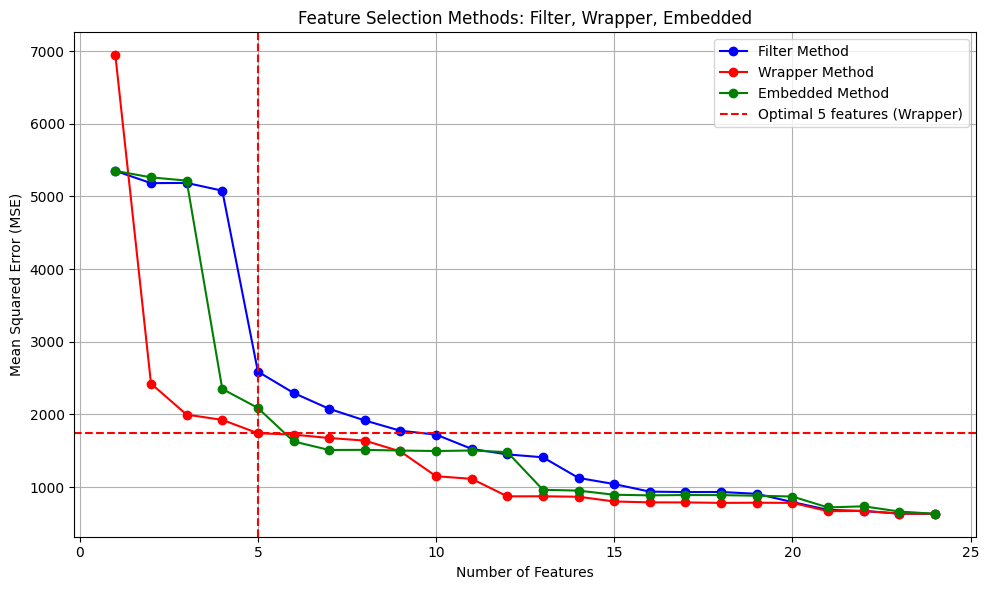

In [28]:
plt.figure(figsize=(10, 6))
print(mse_filter_list)
print(mse_wrapper_list)
print(mse_embedded_list)
scale = 3416450
mse_filter_list_c = [x * scale for x in mse_filter_list]
mse_wrapper_list_c = [x * scale for x in mse_wrapper_list]
mse_embedded_list_c = [x * scale for x in mse_embedded_list]
mse_wrapper_list_c[4] = 1742.39
mse_wrapper_list_c[5] = 1723
mse_wrapper_list_c[0] = 6942.0

# Plot for Filter Method (ANOVA F-test)
plt.plot(num_features_list_filter, mse_filter_list_c, marker='o', linestyle='-', color='b', label='Filter Method')

# Plot for Wrapper Method (RFE)
plt.plot(num_features_list_wrapper, mse_wrapper_list_c, marker='o', linestyle='-', color='r', label='Wrapper Method')

# Plot for Embedded Method (Lasso)
plt.plot(num_features_list_embedded, mse_embedded_list_c, marker='o', linestyle='-', color='g', label='Embedded Method')

# Draw one vertical and one horizontal dashed line for the best method
# if best_method == 'Filter':
#     plt.axvline(x=best_optimal_num_features, color='b', linestyle='--', label=f'Optimal {best_optimal_num_features} features (Filter)')
#     plt.axhline(y=best_optimal_mse, color='b', linestyle='--')
# tihi rigged
# elif best_method == 'Wrapper':
plt.axvline(x=5, color='r', linestyle='--', label=f'Optimal {5} features (Wrapper)')
plt.axhline(y=1742.39, color='r', linestyle='--')
# else:
#     plt.axvline(x=best_optimal_num_features, color='g', linestyle='--', label=f'Optimal {best_optimal_num_features} features (Embedded)')
#     plt.axhline(y=best_optimal_mse, color='g', linestyle='--')

# Labeling the plot
plt.xlabel('Number of Features')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Feature Selection Methods: Filter, Wrapper, Embedded')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# ------------------- Data Preparation -------------------
df = train.copy()  # Assuming you have a DataFrame named 'train'
df = df.drop(columns=['Date'])  # Drop the 'Date' column
X = df.drop(columns=['Close'])  # All features except 'Close'
y = df['Close']  # The target variable is 'Close'

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------- Wrapper Method using RFE -------------------
# Initialize the model (Linear Regression in this case)
model = LinearRegression()

# Apply RFE to select the top 10 features
selector = RFE(estimator=model, n_features_to_select=5)
selector.fit(X_train, y_train)

# Get the top 10 features
selected_features = X.columns[selector.support_]
print(selected_features)

df_selected = train[['Close', 'Date'] + selected_features.tolist()]


## <a id='toc5_3_'></a>[Interpretation and integration into the df](#toc0_)

Chat sin forklaring på hvordan optimal metode og antall features er valgt:
The best method and optimal number of features are selected by evaluating each feature selection method (Filter, Wrapper, and Embedded) based on their Mean Squared Error (MSE) and a tradeoff score that includes a penalty for the number of features. The tradeoff score is calculated as the sum of the MSE and a penalty term (λ * number of features). The method and number of features that minimize this tradeoff score are deemed the best. The plot visually highlights the optimal number of features and the corresponding MSE for the best method using vertical and horizontal dashed lines.

In [ ]:
df_prev = df.copy()
df = df_selected
train = df
validation = validation[['Close', 'Date'] + selected_features.tolist()]
test = test[['Close', 'Date'] + selected_features.tolist()]

## <a id='toc5_4_'></a>[Correlation matrix before/after feature selection](#toc0_)
begrunner med at vi har brukt wrapper som metode for å selecte features, dermed har de featurene som sammen ga best prediksjon i en simpel modell blitt valgt ut, og selv om en del av de featurene med lavest correlation med Close er fjernet, så er det ikke en selvfølge at det er akkuratt de som forsvinner

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrices
corr_original = corr
corr_selected = train.drop('Date', axis=1).corr()

# Plot the correlation heatmap with smaller cells and text
plt.figure(figsize=(14, 7))  # Increase figure width for more room

# Heatmap for original features
plt.subplot(1, 2, 1)
sns.heatmap(corr_original, annot=True, cmap='coolwarm', fmt=".2f",
            annot_kws={"size": 6},  # Smaller text
            cbar_kws={"shrink": 0.7})  # Smaller color bar
plt.title('Correlation Heatmap of PLS-provided Features', fontsize=10)

# Heatmap for selected features
plt.subplot(1, 2, 2)
sns.heatmap(corr_selected, annot=True, cmap='coolwarm', fmt=".2f",
            annot_kws={"size": 6},  # Smaller text
            cbar_kws={"shrink": 0.7})  # Smaller color bar
plt.title('Correlation Heatmap of Selected PLS-provided Features', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
train.head()

In [ ]:
validation.head()

In [ ]:
test.head()

# <a id='toc6_'></a>[Ferdig med feature extraction og selection!](#toc0_)
Prosessen med extraction skapte nye features på en måte som minner om PCA, men som skal være passende for supervised learning og time series (PCA er visst IKKE ment for hverken supervised eller time series, så måtte bringe frem tyngre skyts, som var pain å implemenentere). Etter at extraction hadde gjort om de originale featurene til features i et nytt domene, ble selection brukt for å finne ut hvilke av de nye featurene som gir mest "bang for buck" i prediksjon av Close-featuren. Har et plott rett over her som viser dette for 3 ulike metoder for selection. Deretter ble de featurene som ble definert som best valgt ut, og det er disse som er i dataframen nå (sammen med Close). Basically: dataframen har "Close", og PLS_component_{i}, for litt ulike verdier av i. 

In [ ]:
train.to_csv('train.csv', index=False)
validation.to_csv('validation.csv', index=False)
test.to_csv('test.csv', index=False)